In [1]:
from latentmi import lmi
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import scanpy as sc 
from tqdm.notebook import tqdm
import os

/home/gokul/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
def split_ad(adata, frac=0.8):
    """
    split anndata into ad1 ad2 with ad1 getting frac random cells
    """
    N_cells = len(adata)
    split_ind = int((N_cells*frac)//1)
    # print(split_ind)
    inds = np.arange(N_cells)
    np.random.shuffle(inds)
    return adata[inds[:split_ind]].copy(), adata[inds[split_ind:]].copy()

In [3]:
adata = sc.read_h5ad('../../scaling_playground/data/PBMC_CITEseq_Q1.000_rep0.h5ad')
seen, held_out = split_ad(adata, frac=0.75)

In [4]:
qualities = np.logspace(-3, 0, 10)

In [6]:
d = {
    "Model" : [],
    "UMI per cell" : [],
    "Quality" : [],
    "MI" : [],
    'Target' : []
}

for qual in qualities:
    
    targets = {
        'protein' : held_out.obsm['protein_counts'],
        'cell type' : pd.get_dummies(held_out.obs['celltype.l3']).to_numpy(),
    }

    for target in targets.keys():
        print(f"Quality: {qual}")
        df = pd.read_csv(f"../embeddings/Finetuned/PBMC_CITEseq_G_Q{qual:.3f}_rep0.csv", index_col=0)
        pmis, _, _ = lmi.estimate(df.loc[held_out.obs.index.values], targets[target])

        d['Model'].append("Geneformer")
        d['UMI per cell'].append(adata.raw.X.sum()/len(adata))
        d['Quality'].append(qual)  
        d['MI'].append(np.nanmean(pmis))
        d['Target'].append(target)

    print(f"Geneformer MI: {np.nanmean(pmis)}")

Quality: 0.001
epoch 61 (of max 300) 🌻🌻Quality: 0.001
epoch 151 (of max 300) 🌻🌻🌻🌻🌻Geneformer MI: 0.48718695354264047
Quality: 0.0021544346900318843
epoch 56 (of max 300) 🌻Quality: 0.0021544346900318843
epoch 264 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻Geneformer MI: 0.8873296495792646
Quality: 0.004641588833612777
epoch 61 (of max 300) 🌻🌻Quality: 0.004641588833612777
epoch 230 (of max 300) 🌻🌻🌻🌻🌻🌻🌻Geneformer MI: 1.296711034695141
Quality: 0.01
epoch 95 (of max 300) 🌻🌻🌻Quality: 0.01
epoch 281 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻Geneformer MI: 1.7455522981805276
Quality: 0.021544346900318832
epoch 262 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻Quality: 0.021544346900318832
epoch 299 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻Geneformer MI: 2.176795946709112
Quality: 0.046415888336127774
epoch 204 (of max 300) 🌻🌻🌻🌻🌻🌻Quality: 0.046415888336127774
epoch 299 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻Geneformer MI: 2.574338476394335
Quality: 0.1
epoch 299 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻Quality: 0.1
epoch 280 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻Geneformer MI: 2.9720796438358312
Quality: 0.21544346900318823
epoc

In [7]:
df = pd.DataFrame(d)
df['UMI per cell'] = df['UMI per cell']*df['Quality']
df

,Model,UMI per cell,Quality,MI,Target
0,Geneformer,8.156739,0.001000,0.488416,protein
1,Geneformer,8.156739,0.001000,0.487187,cell type
2,Geneformer,17.573161,0.002154,0.890276,protein
3,Geneformer,17.573161,0.002154,0.887330,cell type
4,Geneformer,37.860228,0.004642,1.301469,protein
5,Geneformer,37.860228,0.004642,1.296711,cell type
6,Geneformer,81.567389,0.010000,1.767440,protein
7,Geneformer,81.567389,0.010000,1.745552,cell type
8,Geneformer,175.731612,0.021544,2.200819,protein
9,Geneformer,175.731612,0.021544,2.176796,cell type


In [10]:
zero_shot = pd.read_csv("../results/PBMC_CITEseq_inference_time_scaling.csv", index_col=0)
zero_shot['UMI per cell'] = zero_shot['UMI per cell']*zero_shot['Quality']
comp_df = pd.concat([zero_shot, df[df['Target'] == 'protein']], axis=0)
comp_df = comp_df[comp_df['Model'] == 'Geneformer']
comp_df['Setting'] = ['Zero-shot']*10 + ['Fine-tuned']*10

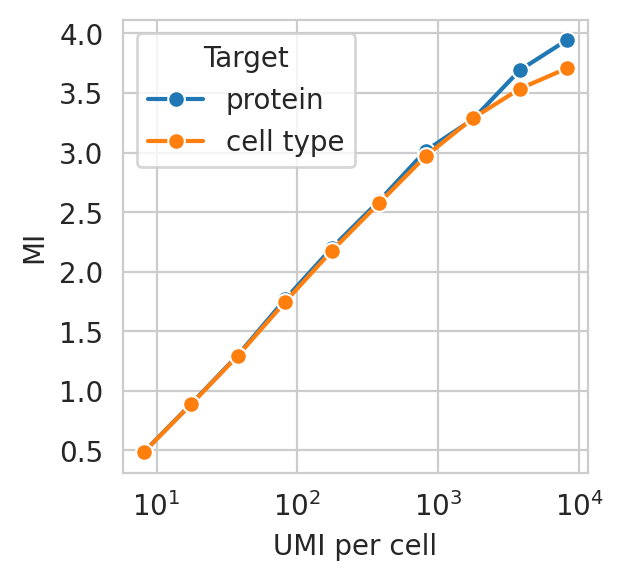

In [11]:
plt.figure(figsize=(3,3), dpi=200)
sns.set_style('whitegrid')
sns.lineplot(data=df, x='UMI per cell', y='MI', hue='Target',
             marker='o')
plt.xscale('log')

In [12]:
from lmfit import Model

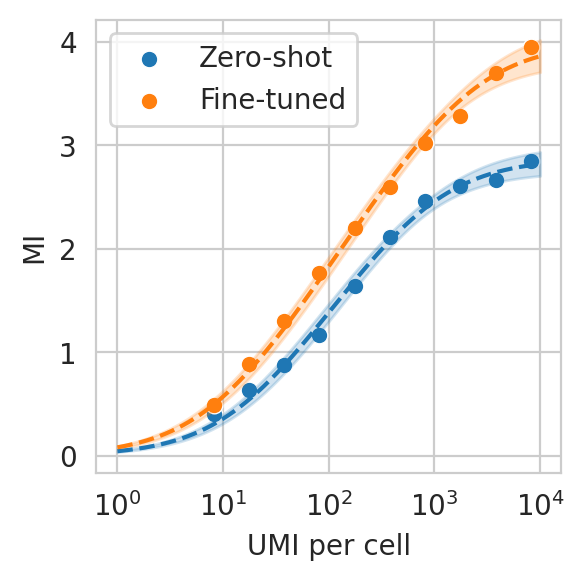

In [13]:
def info_scaling(x, A, B):
    return 0.5 * np.log2(((x)*B+ 1)/(1+A*(x)))

pretty_palette = sns.color_palette('tab10')


plt.figure(figsize=(3,3), dpi=200)

for i, s in enumerate(comp_df['Setting'].unique()):

    ax = sns.scatterplot(data=comp_df[comp_df['Setting'] == s], x='UMI per cell', y='MI',
                         label=s, color=pretty_palette[i], marker='o')

    x_data = comp_df[comp_df['Setting'] == s]['UMI per cell']
    y_data = comp_df[comp_df['Setting'] == s]['MI']

    model = Model(info_scaling)
    params = model.make_params(A=1e-2, B=1e-2)  # initial guesses
    params['A'].min = 0  # set bounds
    params['B'].min = 0

    # fit model
    result = model.fit(y_data, params, x=x_data)

    x_fit = np.logspace(0, 4, 10**3)
    y_fit = model.eval(params=result.params, x=x_fit)

    # calculate confidence bands
    # https://www.astro.rug.nl/software/kapteyn/kmpfittutorial.html#confidence-and-prediction-intervals
    
    y_upper = result.eval_uncertainty(params=result.params, 
                                    x=x_fit, sigma=2)
    y_lower = -y_upper

    ax.fill_between(x_fit, y_fit + y_upper, y_fit + y_lower, color=pretty_palette[i], alpha=0.2)

    ax.plot(x_fit, y_fit, color=pretty_palette[i], linestyle='--')

plt.xscale('log')


In [14]:
df.to_csv("../results/Finetuning_scaling.csv")

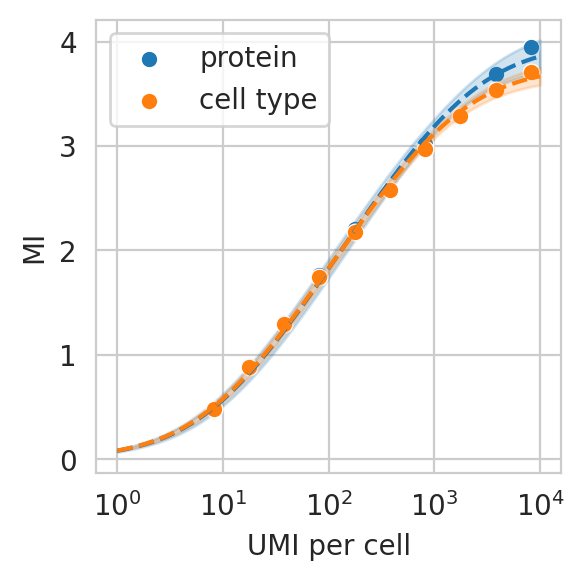

In [22]:
plt.figure(figsize=(3,3), dpi=200)

for i, s in enumerate(df['Target'].unique()):

    ax = sns.scatterplot(data=df[df['Target'] == s], x='UMI per cell', y='MI',
                         label=s, color=pretty_palette[i], marker='o')

    x_data = df[df['Target'] == s]['UMI per cell']
    y_data = df[df['Target'] == s]['MI']

    model = Model(info_scaling)
    params = model.make_params(A=1e-2, B=1e-2)  # initial guesses
    params['A'].min = 0  # set bounds
    params['B'].min = 0

    # fit model
    result = model.fit(y_data, params, x=x_data)

    x_fit = np.logspace(0, 4, 10**3)
    y_fit = model.eval(params=result.params, x=x_fit)

    # calculate confidence bands
    # https://www.astro.rug.nl/software/kapteyn/kmpfittutorial.html#confidence-and-prediction-intervals
    
    y_upper = result.eval_uncertainty(params=result.params, 
                                    x=x_fit, sigma=2)
    y_lower = -y_upper

    ax.fill_between(x_fit, y_fit + y_upper, y_fit + y_lower, color=pretty_palette[i], alpha=0.2)

    ax.plot(x_fit, y_fit, color=pretty_palette[i], linestyle='--')

plt.xscale('log')

In [20]:
df

,Model,UMI per cell,Quality,MI,Target
0,Geneformer,8.156739,0.001000,0.488416,protein
1,Geneformer,8.156739,0.001000,0.487187,cell type
2,Geneformer,17.573161,0.002154,0.890276,protein
3,Geneformer,17.573161,0.002154,0.887330,cell type
4,Geneformer,37.860228,0.004642,1.301469,protein
5,Geneformer,37.860228,0.004642,1.296711,cell type
6,Geneformer,81.567389,0.010000,1.767440,protein
7,Geneformer,81.567389,0.010000,1.745552,cell type
8,Geneformer,175.731612,0.021544,2.200819,protein
9,Geneformer,175.731612,0.021544,2.176796,cell type
